In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau
from cliffs_delta import cliffs_delta

sns.set_theme(style="whitegrid", context='paper', palette='Greys')

## Correlation analysis

In [2]:
data = pd.read_csv("data/bias_symptoms.csv", index_col=[0, 1])

### Correlation symptoms and metrics

In [3]:
important_features = ['unpriv_prob_pos', 'kurtosis_var', 'correlation_true', 'mutual_info', 'pos_prob', 'skew_var', 'priv_prob_pos', 'unbalance', 'unpriv_prob_neg', 'neg_prob', 'priv_prob_neg']

In [4]:
sp_correlations = pd.DataFrame(columns=['Statistical Parity'])
for feature in important_features:
    sp_correlations.loc[feature] = kendalltau(data['statistical_parity'], data[feature])[0]
    print(feature, kendalltau(data['statistical_parity'], data[feature])[1])

unpriv_prob_pos 0.013777508353836107
kurtosis_var 2.333036415799015e-190
correlation_true 9.212812863462586e-07
mutual_info 8.492375235632064e-63
pos_prob 5.307652566752043e-05
skew_var 1.2446062773181145e-132
priv_prob_pos 0.00011875063755321877
unbalance 0.35457473233277015
unpriv_prob_neg 0.013777508353836107
neg_prob 5.306278652691057e-05
priv_prob_neg 0.00011875063755321877


In [5]:
eo_correlations = pd.DataFrame(columns=['Equal Opportunity'])
for feature in important_features:
    eo_correlations.loc[feature] = kendalltau(data['equal_opportunity'], data[feature])[0]
    print(feature, kendalltau(data['equal_opportunity'], data[feature])[1])

unpriv_prob_pos 6.385725373597089e-57
kurtosis_var 0.0
correlation_true 0.8141317834911144
mutual_info 0.001094779419763812
pos_prob 0.003208840916583976
skew_var 4.364499423370414e-277
priv_prob_pos 1.1170689108838824e-06
unbalance 0.07111909004006635
unpriv_prob_neg 6.385725373597089e-57
neg_prob 0.003208760310667286
priv_prob_neg 1.1170689108838824e-06


In [6]:
ao_correlation = pd.DataFrame(columns=['Average Odds'])
for feature in important_features:
    ao_correlation.loc[feature] = kendalltau(data['average_odds'], data[feature])[0]
    print(feature, kendalltau(data['average_odds'], data[feature])[1])

unpriv_prob_pos 5.270346101071394e-09
kurtosis_var 5.715946286866671e-90
correlation_true 0.08406336587212455
mutual_info 4.200782187840812e-25
pos_prob 4.815317287929756e-74
skew_var 4.192197022096708e-46
priv_prob_pos 3.0998309507836878e-99
unbalance 1.5687870816554293e-08
unpriv_prob_neg 5.270346101071394e-09
neg_prob 4.812619557066424e-74
priv_prob_neg 3.0998309507836878e-99


In [7]:
correlations = pd.concat([sp_correlations, eo_correlations, ao_correlation], axis=1)

In [8]:
correlations.to_latex('correlations.tex', float_format="%.3f")

### Correlation between symptoms

In [9]:
data[important_features].corr('kendall').to_latex('correlation_matrix.tex', float_format="%.3f")

In [10]:
# print p values of correlation between features
for feature1 in important_features:
    for feature2 in important_features:
        print(feature1, feature2, kendalltau(data[feature1], data[feature2])[1])

unpriv_prob_pos unpriv_prob_pos 0.0
unpriv_prob_pos kurtosis_var 1.0882338216167122e-43
unpriv_prob_pos correlation_true 0.034159514075288895
unpriv_prob_pos mutual_info 4.0198828206249125e-65
unpriv_prob_pos pos_prob 1.5378447070734712e-38
unpriv_prob_pos skew_var 1.3036041395092385e-11
unpriv_prob_pos priv_prob_pos 2.0802561648594455e-307
unpriv_prob_pos unbalance 5.5431514577473196e-52
unpriv_prob_pos unpriv_prob_neg 0.0
unpriv_prob_pos neg_prob 1.5385043909081945e-38
unpriv_prob_pos priv_prob_neg 2.0802561648594455e-307
kurtosis_var unpriv_prob_pos 1.0882338216167122e-43
kurtosis_var kurtosis_var 0.0
kurtosis_var correlation_true 0.85706221543918
kurtosis_var mutual_info 6.816850366511135e-245
kurtosis_var pos_prob 1.9218229314381373e-10
kurtosis_var skew_var 0.0
kurtosis_var priv_prob_pos 2.3761157233386746e-68
kurtosis_var unbalance 2.297103112972068e-15
kurtosis_var unpriv_prob_neg 1.0882338216167122e-43
kurtosis_var neg_prob 1.922481270871082e-10
kurtosis_var priv_prob_neg 2.37

### Correlation between metrics

In [11]:
data[['statistical_parity', 'equal_opportunity', 'average_odds']].corr('kendall').to_latex('corr_metrics.tex', float_format="%.3f")

In [12]:
for metric in ['statistical_parity', 'equal_opportunity', 'average_odds']:
    for metric2 in ['statistical_parity', 'equal_opportunity', 'average_odds']:
        print(metric, metric2, kendalltau(data[metric], data[metric2])[1])

statistical_parity statistical_parity 0.0
statistical_parity equal_opportunity 5.804213770872034e-173
statistical_parity average_odds 9.615605056299338e-296
equal_opportunity statistical_parity 5.804213770872034e-173
equal_opportunity equal_opportunity 0.0
equal_opportunity average_odds 1.9811524945985082e-30
average_odds statistical_parity 9.615605056299338e-296
average_odds equal_opportunity 1.9811524945985082e-30
average_odds average_odds 0.0


## Distribution of the data

In [13]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=5, aspect=0.5)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[0:4:3],
    )
    g.add_legend()
    g.set_axis_labels("", symp_name)
    plt.savefig(f"figs/{symp_name}.pdf")
    plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))

### Analysis of Mutual Information

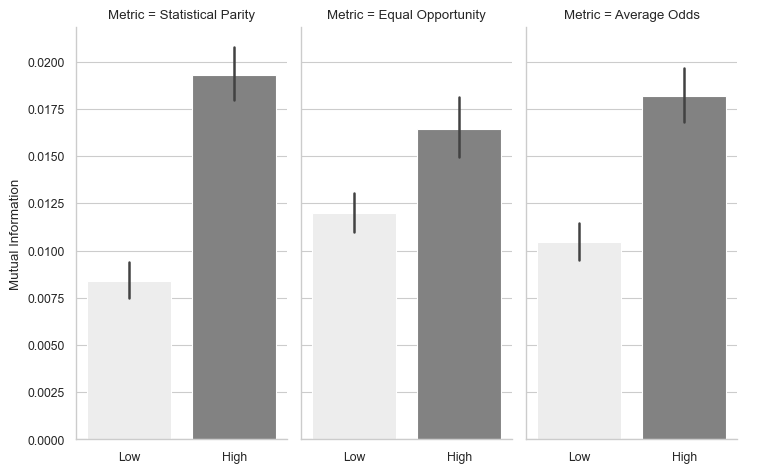

TtestResult(statistic=12.497085116188682, pvalue=2.45608274917653e-35, df=5246.8528586964485)
TtestResult(statistic=4.733197721089503, pvalue=2.2833818521089753e-06, df=4169.738360193492)
TtestResult(statistic=8.52791589326002, pvalue=1.980877415467821e-17, df=4722.979684135725)
(0.25087381402824993, 'small')
(0.05013608365563673, 'negligible')
(0.15698203230461294, 'small')


In [14]:
plot_differences(data, "mutual_info", "Mutual Information")

## Kendall's Tau

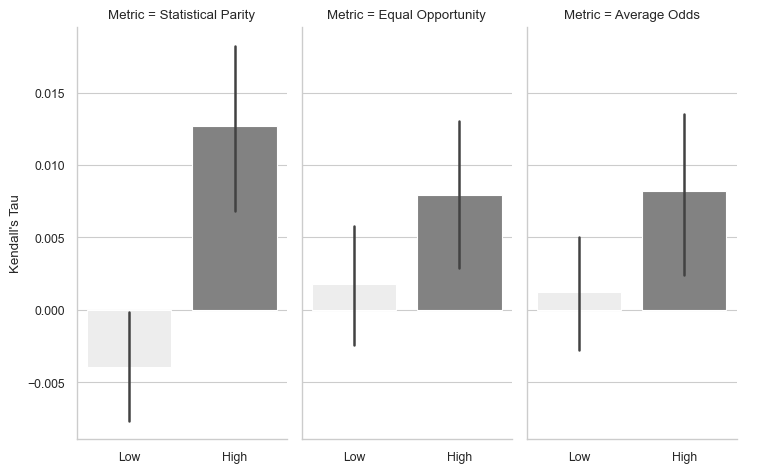

TtestResult(statistic=4.908530046429225, pvalue=9.458185885482086e-07, df=5170.073193669627)
TtestResult(statistic=1.7719437739956236, pvalue=0.07646586247194723, df=4912.757561406061)
TtestResult(statistic=1.974611766131933, pvalue=0.048370223631305304, df=4735.917051195273)
(0.07361203965804185, 'negligible')
(0.003610131985461669, 'negligible')
(0.026203742494065076, 'negligible')


In [15]:
plot_differences(data, "correlation_true", "Kendall's Tau")

## Metrics Distribution

In [16]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              data[data["statistical_parity"] == 0].shape[0]/data.shape[0],
              data[data["statistical_parity"] == 1].shape[0]/data.shape[0],
            ],
            "Equal Opportunity": [
              data[data["equal_opportunity"] == 0].shape[0]/data.shape[0],
              data[data["equal_opportunity"] == 1].shape[0]/data.shape[0],
            ],
            "Average Odds": [
              data[data["average_odds"] == 0].shape[0]/data.shape[0],
              data[data["average_odds"] == 1].shape[0]/data.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [17]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Proportion')

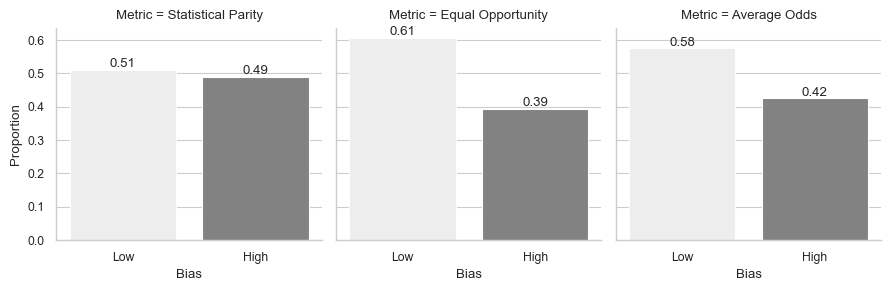

In [18]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Proportion",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[0:4:3],
    height=3,
    aspect=1,
)


g.facet_axis(0, 0).bar_label(g.facet_axis(0, 0).containers[0], fmt="%.2f")
g.facet_axis(0, 0).bar_label(g.facet_axis(0, 0).containers[1], fmt="%.2f")
g.facet_axis(0, 1).bar_label(g.facet_axis(0, 1).containers[0], fmt="%.2f")
g.facet_axis(0, 1).bar_label(g.facet_axis(0, 1).containers[1], fmt="%.2f")
g.facet_axis(0, 2).bar_label(g.facet_axis(0, 2).containers[0], fmt="%.2f")
g.facet_axis(0, 2).bar_label(g.facet_axis(0, 2).containers[1], fmt="%.2f")
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/metrics_distr.pdf", bbox_inches="tight")
plt.show()